In [ ]:
!pip install nilearn
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.6 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Image Segmentation
The image segmentation & time series generation process is in [this notebook, segment-timeseries.ipynb ](https://colab.research.google.com/drive/1JF2CsUnJmpDYZXqbK05vF4rvS7yQkFVY#scrollTo=zV6Km1eE_3JW).
The steps taken to segment the image and corresponding sections of the notebook are as follows:
* download fmri images
* use k-means clustering to create 32 parcellations
* generate time series from k-means segmented and SynthSeg segmented images
* SynthSeg segmentation, which was was done in [this notebook, synth-seg.ipynb](https:///colab.research.google.com/drive/12OxYORGbSE2yhVXHZ-jtnM7q0X-JCmr5#scrollTo=j0wbSnCwHT3v). It is also linked in segment-timeseries.ipynb
* the cell using git clone below loads the result of the time series generation using image segmentation from the two methods

In [ ]:
!git clone https://github.com/r0mmani/connectivity_pd.git

Cloning into 'connectivity_pd'...
remote: Enumerating objects: 519, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 519 (delta 6), reused 229 (delta 1), pack-reused 282
Receiving objects: 100% (519/519), 78.90 MiB | 16.05 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (363/363), done.


In [ ]:
from nilearn import image, plotting, datasets, signal
from nilearn.maskers import NiftiMapsMasker
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from nilearn.connectome import ConnectivityMeasure
from torch_geometric.utils.convert import to_networkx

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Dropout
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv, global_mean_pool
import torch_geometric.nn as gnn

from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random

(300, 50)


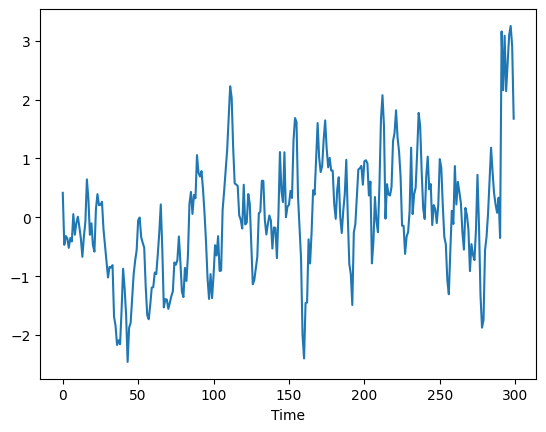

In [ ]:
path = '/content/connectivity_pd/time_series'
subject_id = 'RC4113'
session = 'ses-1'
time_series_file = os.path.join(path, f'{subject_id}-{session}.csv')
time_series = np.loadtxt(time_series_file, dtype=float, delimiter=',')
print(time_series.shape)
plt.plot(time_series[:,4])
plt.xlabel('Time')
plt.show()

In [ ]:
time_series = []
labels = []
for i, csv_file in enumerate(sorted(os.listdir(path))):
  time_series_file = os.path.join(path, csv_file)
  time_series.append(np.loadtxt(time_series_file, dtype=float, delimiter=','))
  labels.append(int(int(csv_file[3]) == 1))

In [ ]:
corr_measure = ConnectivityMeasure(kind='correlation')
pcorr_measure = ConnectivityMeasure(kind='partial correlation')

corr_matrices = corr_measure.fit_transform(time_series)
pcorr_matrices = pcorr_measure.fit_transform(time_series)

graphs = []
neighbors = 20 # Graph Complexity Hyperparameter
for i in range(0, len(corr_matrices)):
    index = np.abs(pcorr_matrices[i]).argsort(axis=1)
    n_rois = pcorr_matrices[i].shape[0]

    # Take only the top k correlates to reduce number of edges
    for j in range(n_rois):
        for k in range(n_rois - neighbors):
            pcorr_matrices[i][j, index[j, k]] = 0

    pcorr_matrix_nx = nx.from_numpy_array(pcorr_matrices[i])
    pcorr_matrix_data = from_networkx(pcorr_matrix_nx)
    pcorr_matrix_data.x = torch.tensor(corr_matrices[i]).float()
    pcorr_matrix_data.y = torch.tensor(labels[i], dtype=torch.long)
    graphs.append(pcorr_matrix_data)

/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/usr/local/lib/python3.10/dist

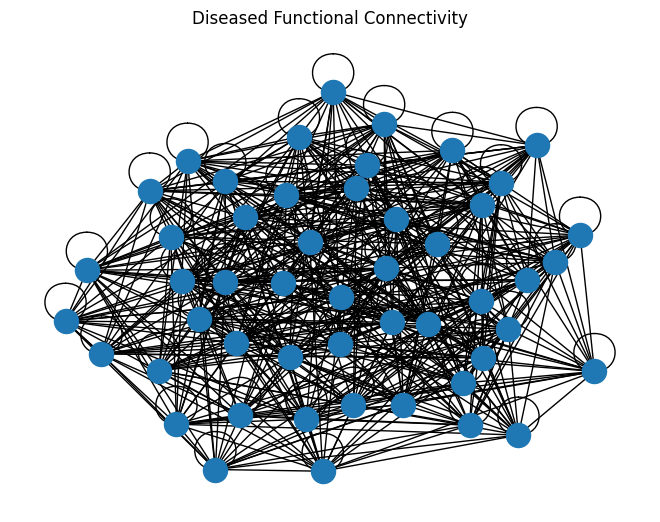

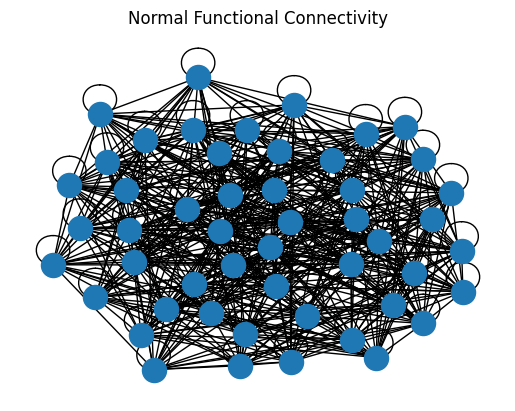

In [ ]:
g = to_networkx(graphs[78], to_undirected=True)
nx.draw(g)
plt.title('Diseased Functional Connectivity')

plt.figure()
g = to_networkx(graphs[2], to_undirected=True)
plt.title('Normal Functional Connectivity')
nx.draw(g)

# Experiment 1

### Baseline Model and Results


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, Sigmoid
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv, global_mean_pool
class GCN(torch.nn.Module):
  def __init__(self, num_node_features, hidden_channels):
    super(GCN, self).__init__()
    self.conv1 = GraphConv(num_node_features, hidden_channels)
    self.conv2 = GraphConv(hidden_channels, hidden_channels)
    self.conv3 = GraphConv(hidden_channels, hidden_channels)
    #self.conv4 = GraphConv(hidden_channels, hidden_channels)
    self.bn1 = BatchNorm1d(hidden_channels)
    self.bn2 = BatchNorm1d(hidden_channels)
    self.bn3 = BatchNorm1d(hidden_channels)
    #self.bn4 = BatchNorm1d(hidden_channels)
    self.sigmoid = Sigmoid()
    self.fc = Linear(hidden_channels, 1)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.conv1(x, edge_index)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.conv2(x, edge_index)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.conv3(x, edge_index)
    x = self.bn3(x)

    x = global_mean_pool(x, batch)
    x = F.dropout(x, p=0.75)
    x = self.fc(x)
    x = self.sigmoid(x)

    return x

In [ ]:
def train(model, train_loader):
  model.train()
  for data in train_loader:
    y = data.y.unsqueeze(1)
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.float(), y.float())
    loss.backward()
    optimizer.step()

def test(model, loader):
  model.eval()
  correct = 0
  for data in loader:
    y = data.y.unsqueeze(1)
    out = model(data)
    pred = torch.where(out > threshold, 1, 0)
    loss = criterion(out.float(), y.float())
    correct += torch.eq(y, pred).sum()
  return correct / len(loader.dataset), loss.item()

In [ ]:
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random

# for x in range(3):
lr = 1e-2
criterion = torch.nn.BCELoss()
num_epochs = 10
threshold = 0.5
batch_size = 32
model = GCN(num_node_features=50, hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

torch.manual_seed(12345)
random.shuffle(graphs)
train_size = int(0.8 * len(graphs))
val_size = len(graphs) - train_size
train_dataset, val_dataset = random_split(graphs, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    #print(len(train_loader.dataset))
    #print(len(valid_loader.dataset))

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_test_loss = []
avg_train_acc = []
avg_val_acc = []
avg_train_loss = []
avg_test_loss = []
for epoch in range(1, num_epochs+1):
  train(model, train_loader)
  train_acc, bceloss_train = test(model, train_loader)
  val_acc, bceloss_test = test(model, valid_loader)
  #if epoch % 10 == 0:
  #print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}, Training Loss: {bceloss_train:.4f}, Validation Loss: {bceloss_test:.4f}')
  all_train_acc.append(train_acc)
  all_val_acc.append(val_acc)
  all_train_loss.append(bceloss_train)
  all_test_loss.append(bceloss_test)
    # if epoch==num_epochs:
    #   avg_train_acc.append(max(all_train_acc))
    #   avg_val_acc.append(max(all_val_acc))
    #   avg_train_loss.append(min(all_train_loss))
    #   avg_test_loss.append(min(all_test_loss))

# print(sum(avg_train_acc)/len(avg_train_acc))
# print(sum(avg_val_acc)/len(avg_val_acc))
# print(sum(avg_train_loss)/len(avg_train_loss))
# print(sum(avg_test_loss)/len(avg_test_loss))

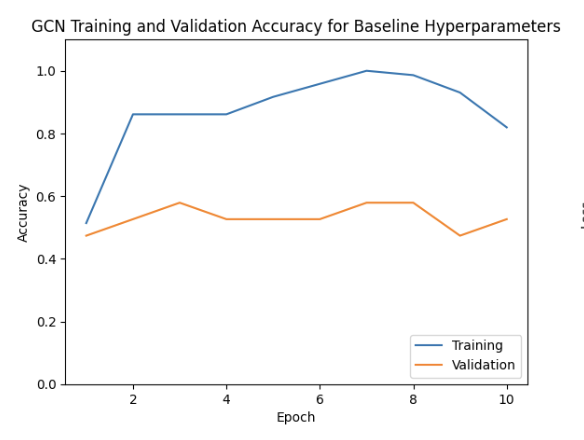

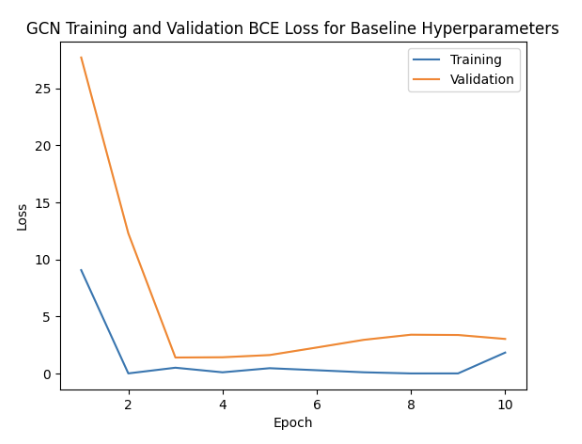

### Model with Optimized Architecture

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, Sigmoid
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv, global_mean_pool
class GCN(torch.nn.Module):
  def __init__(self, num_node_features, hidden_channels):
    super(GCN, self).__init__()
    self.conv1 = GraphConv(num_node_features, hidden_channels)
    self.conv2 = GraphConv(hidden_channels, hidden_channels)
    self.conv3 = GraphConv(hidden_channels, hidden_channels)
    self.conv4 = GraphConv(hidden_channels, hidden_channels)
    self.bn1 = BatchNorm1d(hidden_channels)
    self.bn2 = BatchNorm1d(hidden_channels)
    self.bn3 = BatchNorm1d(hidden_channels)
    self.bn4 = BatchNorm1d(hidden_channels)
    self.sigmoid = Sigmoid()
    self.fc = Linear(hidden_channels, 1)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.conv1(x, edge_index)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.conv2(x, edge_index)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.conv3(x, edge_index)
    x = self.bn3(x)
    x = F.relu(x)

    x = self.conv4(x, edge_index)
    x = self.bn4(x)

    x = global_mean_pool(x, batch)
    x = F.dropout(x, p=0.75)
    x = self.fc(x)
    x = self.sigmoid(x)

    return x

In [ ]:
def train(model, train_loader):
  model.train()
  for data in train_loader:
    y = data.y.unsqueeze(1)
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.float(), y.float())
    loss.backward()
    optimizer.step()

def test(model, loader):
  model.eval()
  correct = 0
  for data in loader:
    y = data.y.unsqueeze(1)
    out = model(data)
    pred = torch.where(out > threshold, 1, 0)
    loss = criterion(out.float(), y.float())
    correct += torch.eq(y, pred).sum()
  return correct / len(loader.dataset), loss.item()

In [ ]:
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random

# for x in range(3):
lr = 1e-2
criterion = torch.nn.BCELoss()
num_epochs = 10
threshold = 0.5
batch_size = 32
model = GCN(num_node_features=50, hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

torch.manual_seed(12345)
random.shuffle(graphs)
train_size = int(0.8 * len(graphs))
val_size = len(graphs) - train_size
train_dataset, val_dataset = random_split(graphs, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    #print(len(train_loader.dataset))
    #print(len(valid_loader.dataset))

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_test_loss = []
avg_train_acc = []
avg_val_acc = []
avg_train_loss = []
avg_test_loss = []
for epoch in range(1, num_epochs+1):
  train(model, train_loader)
  train_acc, bceloss_train = test(model, train_loader)
  val_acc, bceloss_test = test(model, valid_loader)
  #if epoch % 10 == 0:
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}, Training Loss: {bceloss_train:.4f}, Validation Loss: {bceloss_test:.4f}')
  all_train_acc.append(train_acc)
  all_val_acc.append(val_acc)
  all_train_loss.append(bceloss_train)
  all_test_loss.append(bceloss_test)
    # if epoch==num_epochs:
    #   avg_train_acc.append(max(all_train_acc))
    #   avg_val_acc.append(max(all_val_acc))
    #   avg_train_loss.append(min(all_train_loss))
    #   avg_test_loss.append(min(all_test_loss))

# print(sum(avg_train_acc)/len(avg_train_acc))
# print(sum(avg_val_acc)/len(avg_val_acc))
# print(sum(avg_train_loss)/len(avg_train_loss))
# print(sum(avg_test_loss)/len(avg_test_loss))

Epoch: 001, Train Acc: 0.5972, Validation Acc: 0.4737, Training Loss: 28.2007, Validation Loss: 43.6764
Epoch: 002, Train Acc: 0.6528, Validation Acc: 0.4211, Training Loss: 19.5156, Validation Loss: 38.7032
Epoch: 003, Train Acc: 0.7778, Validation Acc: 0.5263, Training Loss: 0.2392, Validation Loss: 22.9702
Epoch: 004, Train Acc: 0.8194, Validation Acc: 0.6316, Training Loss: 0.1975, Validation Loss: 1.7234
Epoch: 005, Train Acc: 0.8889, Validation Acc: 0.5263, Training Loss: 0.2690, Validation Loss: 1.7475
Epoch: 006, Train Acc: 0.8750, Validation Acc: 0.4211, Training Loss: 0.1557, Validation Loss: 3.0959
Epoch: 007, Train Acc: 0.9583, Validation Acc: 0.4737, Training Loss: 0.0016, Validation Loss: 3.6561
Epoch: 008, Train Acc: 0.8333, Validation Acc: 0.7895, Training Loss: 0.5064, Validation Loss: 1.1914
Epoch: 009, Train Acc: 0.8333, Validation Acc: 0.7895, Training Loss: 0.0725, Validation Loss: 0.7055
Epoch: 010, Train Acc: 0.9028, Validation Acc: 0.7368, Training Loss: 0.0696,

In [ ]:
plt.plot(range(1, num_epochs+1),all_train_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.plot(range(1, num_epochs+1),all_val_acc)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.title("GCN Training and Validation Accuracy for Baseline Hyperparameters")
plt.show()

plt.plot(range(1, num_epochs+1), all_train_loss)
plt.plot(range(1, num_epochs+1), all_test_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("GCN Training and Validation BCE Loss for Baseline Hyperparameters")
plt.show()

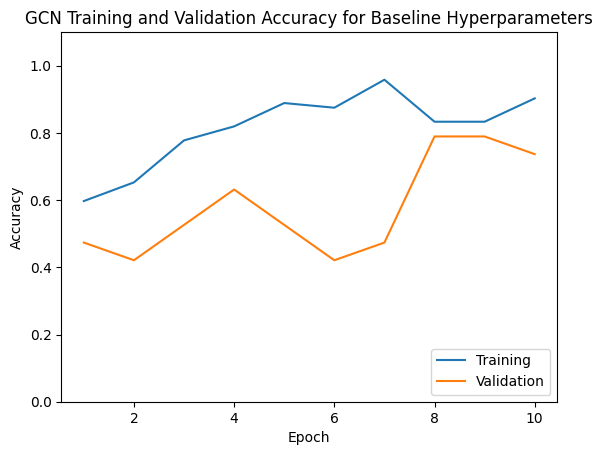

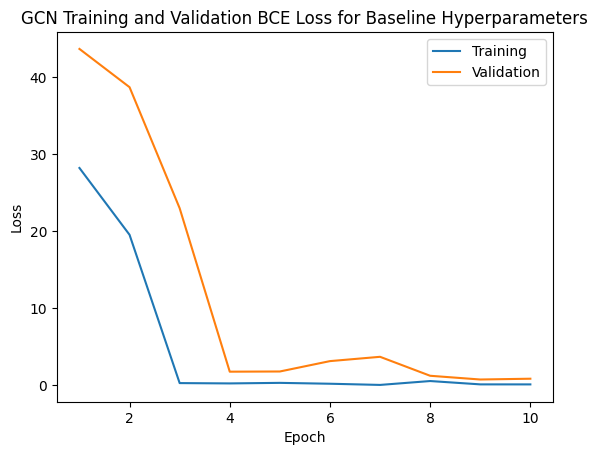

### Fully Optimized Model (Optimized Architecure and Hyperparameters)

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, Sigmoid
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv, global_mean_pool
class GCN(torch.nn.Module):
  def __init__(self, num_node_features, hidden_channels):
    super(GCN, self).__init__()
    self.conv1 = GraphConv(num_node_features, hidden_channels)
    self.conv2 = GraphConv(hidden_channels, hidden_channels)
    self.conv3 = GraphConv(hidden_channels, hidden_channels)
    self.conv4 = GraphConv(hidden_channels, hidden_channels)
    self.bn1 = BatchNorm1d(hidden_channels)
    self.bn2 = BatchNorm1d(hidden_channels)
    self.bn3 = BatchNorm1d(hidden_channels)
    self.bn4 = BatchNorm1d(hidden_channels)
    self.sigmoid = Sigmoid()
    self.fc = Linear(hidden_channels, 1)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.conv1(x, edge_index)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.conv2(x, edge_index)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.conv3(x, edge_index)
    x = self.bn3(x)
    x = F.relu(x)

    x = self.conv4(x, edge_index)
    x = self.bn4(x)

    x = global_mean_pool(x, batch)
    x = F.dropout(x, p=0.75)
    x = self.fc(x)
    x = self.sigmoid(x)

    return x

In [ ]:
def train(model, train_loader):
  model.train()
  for data in train_loader:
    y = data.y.unsqueeze(1)
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.float(), y.float())
    loss.backward()
    optimizer.step()

def test(model, loader):
  model.eval()
  correct = 0
  for data in loader:
    y = data.y.unsqueeze(1)
    out = model(data)
    pred = torch.where(out > threshold, 1, 0)
    loss = criterion(out.float(), y.float())
    correct += torch.eq(y, pred).sum()
  return correct / len(loader.dataset), loss.item()

In [ ]:
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random

lr = 1e-3
criterion = torch.nn.BCELoss()
num_epochs = 10
threshold = 0.6
batch_size = 22
hidden=128
model = GCN(num_node_features=50, hidden_channels=hidden)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

torch.manual_seed(0)
random.shuffle(graphs)
train_size = int(0.8 * len(graphs))
val_size = len(graphs) - train_size
train_dataset, val_dataset = random_split(graphs, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_test_loss = []

for epoch in range(1, num_epochs+1):
  train(model, train_loader)
  train_acc, bceloss_train = test(model, train_loader)
  val_acc, bceloss_test = test(model, valid_loader)
  if epoch % 1 == 0:
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}, Training Loss: {bceloss_train:.4f}, Validation Loss: {bceloss_test:.4f}')

  all_train_acc.append(train_acc.item())
  all_val_acc.append(val_acc.item())
  all_train_loss.append(bceloss_train)
  all_test_loss.append(bceloss_test)


# print(sum(avg_train_acc)/len(avg_train_acc))
# print(sum(avg_val_acc)/len(avg_val_acc))
# print(sum(avg_train_loss)/len(avg_train_loss))
# print(sum(avg_test_loss)/len(avg_test_loss))
print(all_train_acc[9])
print(all_val_acc[9])
print(all_train_loss[9])
print(all_test_loss[9])



Epoch: 001, Train Acc: 0.5278, Validation Acc: 0.3158, Training Loss: 2.0724, Validation Loss: 9.7311
Epoch: 002, Train Acc: 0.6111, Validation Acc: 0.5789, Training Loss: 0.1712, Validation Loss: 2.6472
Epoch: 003, Train Acc: 0.7083, Validation Acc: 0.5263, Training Loss: 0.6344, Validation Loss: 2.1652
Epoch: 004, Train Acc: 0.7778, Validation Acc: 0.6842, Training Loss: 0.5425, Validation Loss: 0.9920
Epoch: 005, Train Acc: 0.8472, Validation Acc: 0.6842, Training Loss: 0.6976, Validation Loss: 0.8289
Epoch: 006, Train Acc: 0.8750, Validation Acc: 0.6316, Training Loss: 0.0657, Validation Loss: 0.8591
Epoch: 007, Train Acc: 0.9167, Validation Acc: 0.7368, Training Loss: 0.1163, Validation Loss: 0.9368
Epoch: 008, Train Acc: 0.9444, Validation Acc: 0.7895, Training Loss: 0.2148, Validation Loss: 0.9404
Epoch: 009, Train Acc: 0.9722, Validation Acc: 0.7895, Training Loss: 0.0936, Validation Loss: 1.0260
Epoch: 010, Train Acc: 0.9861, Validation Acc: 0.7895, Training Loss: 0.0310, Vali

In [ ]:
plt.plot(range(1, num_epochs+1),all_train_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.plot(range(1, num_epochs+1),all_val_acc)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.title("GCN Training and Validation Accuracy for Optimal Hyperparameters")
plt.show()

plt.plot(range(1, num_epochs+1), all_train_loss)
plt.plot(range(1, num_epochs+1), all_test_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("GCN Training and Validation BCE Loss for Optimal Hyperparameters")
plt.show()

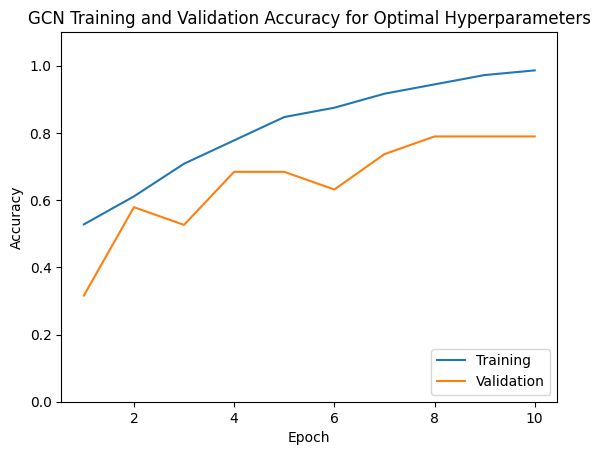

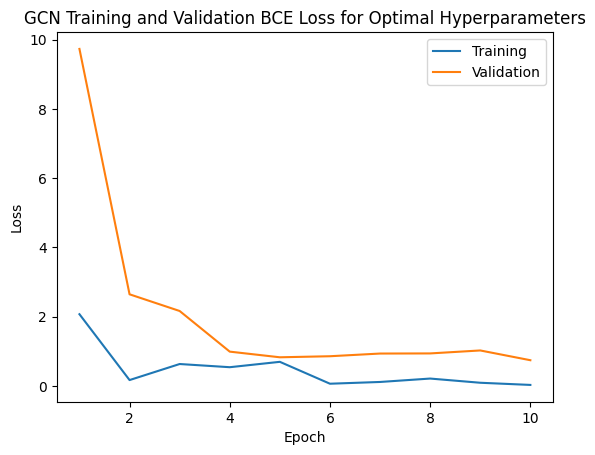

# Experiment 2


*   k-means clustering with 32 parcellations
*   SynthSeg segmentation with 32 regions: https://colab.research.google.com/drive/12OxYORGbSE2yhVXHZ-jtnM7q0X-JCmr5?usp=sharing
* for each segmentation method, all combinations of various hyperparameters were iterated through several times.



# K-means Clustering with 32 parcellations

In [ ]:
from nilearn import image, plotting, datasets, signal
from nilearn.maskers import NiftiMapsMasker
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
files = os.listdir('/content/connectivity_pd/time_series_2')
path = '/content/connectivity_pd/time_series_2'
shape = []
for f in files:
  time_series_file = os.path.join(path, f)
  time_series = np.loadtxt(time_series_file, dtype=float, delimiter=',')
  shape.append(time_series.shape)

In [ ]:
time_series = []
labels = []
shapes = []
for i, csv_file in enumerate(sorted(os.listdir(path))):
  time_series_file = os.path.join(path, csv_file)

  time_series.append(np.loadtxt(time_series_file, dtype=float, delimiter=','))
  labels.append(int(int(csv_file[3]) == 1))

In [ ]:
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from nilearn.connectome import ConnectivityMeasure

corr_measure = ConnectivityMeasure(kind='correlation')
pcorr_measure = ConnectivityMeasure(kind='partial correlation')

corr_matrices = corr_measure.fit_transform(time_series)
pcorr_matrices = pcorr_measure.fit_transform(time_series)

graphs = []
neighbors = 20
for i in range(0, len(corr_matrices)):
    index = np.abs(pcorr_matrices[i]).argsort(axis=1)
    n_rois = pcorr_matrices[i].shape[0]

    # Take only the top k correlates to reduce number of edges
    for j in range(n_rois):
        for k in range(n_rois - neighbors):
            pcorr_matrices[i][j, index[j, k]] = 0
        for k in range(n_rois - neighbors, n_rois):
            pcorr_matrices[i][j, index[j, k]] = 1

    pcorr_matrix_nx = nx.from_numpy_array(pcorr_matrices[i])
    pcorr_matrix_data = from_networkx(pcorr_matrix_nx)
    pcorr_matrix_data.x = torch.tensor(corr_matrices[i]).float()
    pcorr_matrix_data.y = torch.tensor(labels[i], dtype=torch.long)
    #pcorr_matrix_data = np.array(pcorr_matrix_data)
    graphs.append(pcorr_matrix_data)

/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/usr/local/lib/python3.10/dist

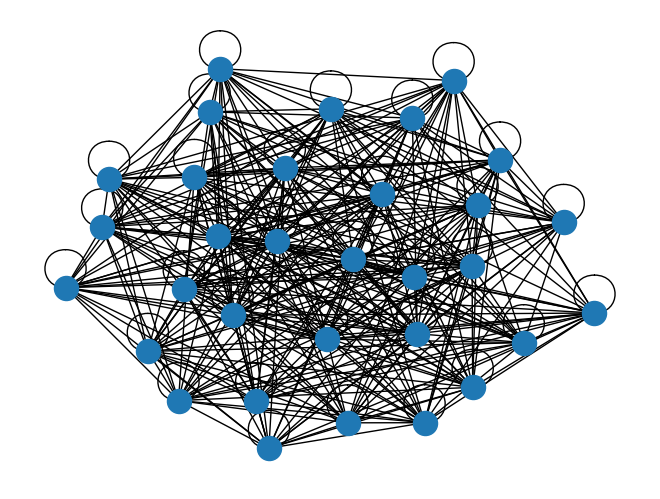

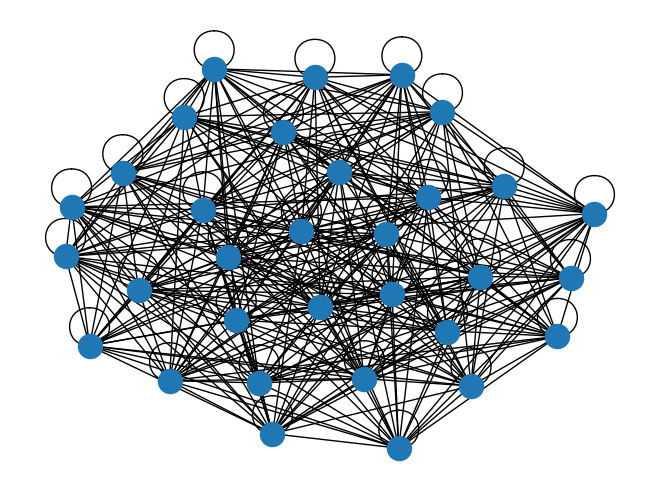

In [ ]:
from torch_geometric.utils.convert import to_networkx
g = to_networkx(graphs[78], to_undirected=True)
nx.draw(g)

plt.figure()
g = to_networkx(graphs[2], to_undirected=True)
nx.draw(g)

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Sigmoid
from torch_geometric.nn import GraphConv, global_mean_pool
class GCN(torch.nn.Module):
  def __init__(self, num_node_features, hidden_channels):
    super(GCN, self).__init__()
    self.conv1 = GraphConv(num_node_features, hidden_channels)
    self.conv2 = GraphConv(hidden_channels, hidden_channels)
    self.conv3 = GraphConv(hidden_channels, hidden_channels)
    self.conv4 = GraphConv(hidden_channels, hidden_channels)
    self.bn1 = BatchNorm1d(hidden_channels)
    self.bn2 = BatchNorm1d(hidden_channels)
    self.bn3 = BatchNorm1d(hidden_channels)
    self.bn4 = BatchNorm1d(hidden_channels)
    self.sigmoid = Sigmoid()
    self.fc = Linear(hidden_channels, 1)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.conv1(x, edge_index)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.conv2(x, edge_index)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.conv3(x, edge_index)
    x = self.bn3(x)
    x = F.relu(x)

    x = self.conv4(x, edge_index)
    x = self.bn4(x)

    x = global_mean_pool(x, batch)
    x = F.dropout(x, p=0.75)
    x = self.fc(x)
    x = self.sigmoid(x)

    return x

In [ ]:
import numpy as np
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random

def train(model, train_loader, optimizer):
  criterion = torch.nn.BCELoss()
  model.train()
  for data in train_loader:
    y = data.y.unsqueeze(1)
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.float(), y.float())
    loss.backward()
    optimizer.step()

def test(model, loader, threshold):
  criterion = torch.nn.BCELoss()
  model.eval()
  correct = 0
  for data in loader:
    y = data.y.unsqueeze(1)
    out = model(data)
    pred = torch.where(out > threshold, 1, 0)
    loss = criterion(out.float(), y.float())
    correct += torch.eq(y, pred).sum()
  return correct / len(loader.dataset), loss.item()

Function to iterate through several hyperparameter values.

In [ ]:

import numpy as np
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random

def test_hyperParams(lr,num_epochs,threshold,batchsize):
  lr = lr
  num_epochs = num_epochs
  threshold = threshold
  batch_size = batchsize
  criterion = torch.nn.BCELoss()
  model = GCN(num_node_features=32, hidden_channels=128)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  torch.manual_seed(12345)
  random.shuffle(graphs)
  train_size = int(0.8 * len(graphs))
  val_size = len(graphs) - train_size
  train_dataset, val_dataset = random_split(graphs, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    #print(len(train_loader.dataset))
    #print(len(valid_loader.dataset))

  all_train_acc = []
  all_val_acc = []
  all_train_loss = []
  all_test_loss = []


  for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer)
    train_acc, bceloss_train = test(model, train_loader, threshold)
    val_acc, bceloss_test = test(model, valid_loader, threshold)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)
    all_train_loss.append(bceloss_train)
    all_test_loss.append(bceloss_test)


  return all_train_acc, all_val_acc, all_train_loss, all_test_loss



In [ ]:
import numpy as np
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random

lrs = [1e-1, 1e-2, 1e-3]
nums_epochs = [10, 20, 30, 40, 50]
ts = [0.6, 0.7, 0.75]
batchsizes = [16, 20, 22]
#lr = 1e-4


#lrs = [1e-4]
#nums_epochs = [10]
#ts = [0.6]
#batchsizes = [22]
#model = GCN(num_node_features=50, hidden_channels=128)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)

all_iter_train_acc = []
all_iter_val_acc = []
all_iter_train_loss = []
all_iter_test_loss = []

hp_set = []
trainlosses = []
testlosses = []
trainacc = []
valacc = []
it = 0
avg_losses = []
for n in nums_epochs:
  for r in lrs:
    for t in ts:
      for b in batchsizes:
        all_train_acc, all_val_acc, all_train_loss, all_test_loss = test_hyperParams(r, n, t, b)
        min_train_loss = np.min(all_train_loss)
        min_test_loss = np.min(all_test_loss)
        max_train_acc = np.max(all_train_acc)
        max_val_acc = np.max(all_val_acc)
        print('best training accuracy:', max_train_acc,'\n', 'best validation accuracy:', max_val_acc, '\n',
              'best training loss:', min_train_loss,'\n',
              'best test loss:', min_test_loss, '\n', '------------------------------------------------' )
        print('num_epochs', n, 'lr', r, 'threshold',t, 'batch size', b, '\n', '------------------------------------------------')
        hp_set.append(['num_epochs', n, 'lr', r, 'threshold', t, 'batch size', b])
        trainlosses.append(min_train_loss)
        testlosses.append(min_test_loss)
        avg_loss = (min_train_loss + min_test_loss )/ 2
        avg_losses.append(avg_loss)
        trainacc.append(max_train_acc)
        valacc.append(max_val_acc)
        all_iter_train_acc.append(all_train_acc)
        all_iter_val_acc.append(all_val_acc)
        all_iter_train_loss.append(all_train_loss)
        all_iter_test_loss.append(all_test_loss)

        it += 1
print('------------------------------------------------------------------------------------------')
v = testlosses.index(np.min(testlosses))
print('iteration with the best test losses:', v)
epoch_min_val_loss = all_iter_test_loss[v].index(np.min(testlosses))
print('hyperparams:', hp_set[v],'\n','validation accuracy:', np.max(all_iter_val_acc[v]),
      'val loss:', testlosses[v],'\n' ,'train loss:', trainlosses[v], '\n' ,
      'train accuracy:', trainacc[v])
print('epoch of min val loss:', epoch_min_val_loss )
print('-----------------------------------------------------------------------------------------')

b = valacc.index(np.max(valacc))
print('iteration with the best validation accuracy:', b)
epoch_max_val_acc = all_iter_val_acc[b].index(np.max(valacc))
print('hyperparams:', hp_set[b],'\n','validation accuracy:', np.max(all_iter_val_acc[b]),
      'val loss:', np.min(all_iter_test_loss[b]),'\n' ,'train loss:', trainlosses[b], '\n' ,
      'train accuracy:', trainacc[b])
print('epoch of max val accuracy:', epoch_max_val_acc )
print('-----------------------------------------------------------------------------------------')

c = trainacc.index(np.max(trainacc))
print('iteration with the best train accuracy:', c)
epoch_max_train_acc = all_iter_train_acc[c].index(np.max(trainacc))
print('hyperparams:', hp_set[c],'\n','validation accuracy:', np.max(all_iter_val_acc[c]),
      'val loss:', testlosses[c],'\n' ,'train loss:', trainlosses[c], '\n' ,
      'train accuracy:', trainacc[c])
print('epoch of max train accuracy:', epoch_max_train_acc )
print('-----------------------------------------------------------------------------------------')



best training accuracy: 0.8194444 
 best validation accuracy: 0.68421054 
 best training loss: 0.01223035529255867 
 best test loss: 6.66490029398864e-13 
 ------------------------------------------------
num_epochs 10 lr 0.1 threshold 0.6 batch size 16 
 ------------------------------------------------
best training accuracy: 0.7777778 
 best validation accuracy: 0.68421054 
 best training loss: 0.36422884464263916 
 best test loss: 2.913832664489746 
 ------------------------------------------------
num_epochs 10 lr 0.1 threshold 0.6 batch size 20 
 ------------------------------------------------
best training accuracy: 0.6111111 
 best validation accuracy: 0.7368421 
 best training loss: 0.1491871029138565 
 best test loss: 3.052402973175049 
 ------------------------------------------------
num_epochs 10 lr 0.1 threshold 0.6 batch size 22 
 ------------------------------------------------
best training accuracy: 0.7361111 
 best validation accuracy: 0.68421054 
 best training loss

In [ ]:
print('------------------------------------------------------------------------------------------')
v = testlosses.index(np.min(testlosses))
print('iteration with the best test losses:', v)
epoch_min_val_loss = all_iter_test_loss[v].index(np.min(testlosses))
print('hyperparams:', hp_set[v],'\n','validation accuracy:', np.max(all_iter_val_acc[v]),
      'val loss:', testlosses[v],'\n' ,'train loss:', trainlosses[v], '\n' ,
      'train accuracy:', trainacc[v])
print('epoch of min val loss:', epoch_min_val_loss )
print('-----------------------------------------------------------------------------------------')

b = valacc.index(np.max(valacc))
print('iteration with the best validation accuracy:', b)
epoch_max_val_acc = all_iter_val_acc[b].index(np.max(valacc))
print('hyperparams:', hp_set[b],'\n','validation accuracy:', np.max(all_iter_val_acc[b]),
      'val loss:', np.min(all_iter_test_loss[b]),'\n' ,'train loss:', trainlosses[b], '\n' ,
      'train accuracy:', trainacc[b])
print('epoch of max val accuracy:', epoch_max_val_acc )
print('-----------------------------------------------------------------------------------------')

c = trainacc.index(np.max(trainacc))
print('iteration with the best train accuracy:', c)
epoch_max_train_acc = all_iter_train_acc[c].index(np.max(trainacc))
print('hyperparams:', hp_set[c],'\n','validation accuracy:', np.max(all_iter_val_acc[c]),
      'val loss:', testlosses[c],'\n' ,'train loss:', trainlosses[c], '\n' ,
      'train accuracy:', trainacc[c])
print('epoch of max train accuracy:', epoch_max_train_acc )
print('-----------------------------------------------------------------------------------------')



------------------------------------------------------------------------------------------
iteration with the best test losses: 0
hyperparams: ['num_epochs', 10, 'lr', 0.1, 'threshold', 0.6, 'batch size', 16] 
 validation accuracy: 0.68421054 val loss: 6.66490029398864e-13 
 train loss: 0.01223035529255867 
 train accuracy: 0.8194444
epoch of min val loss: 7
-----------------------------------------------------------------------------------------
iteration with the best validation accuracy: 72
hyperparams: ['num_epochs', 30, 'lr', 0.001, 'threshold', 0.6, 'batch size', 16] 
 validation accuracy: 0.84210527 val loss: 0.6237546801567078 
 train loss: 0.007260902319103479 
 train accuracy: 1.0
epoch of max val accuracy: 8
-----------------------------------------------------------------------------------------
iteration with the best train accuracy: 9
hyperparams: ['num_epochs', 10, 'lr', 0.01, 'threshold', 0.6, 'batch size', 16] 
 validation accuracy: 0.68421054 val loss: 4.7909583145155

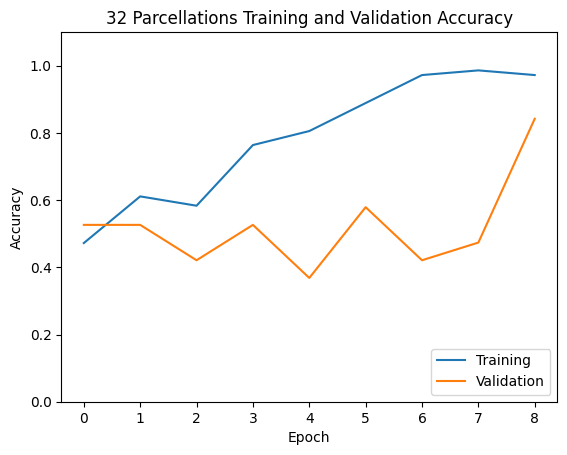

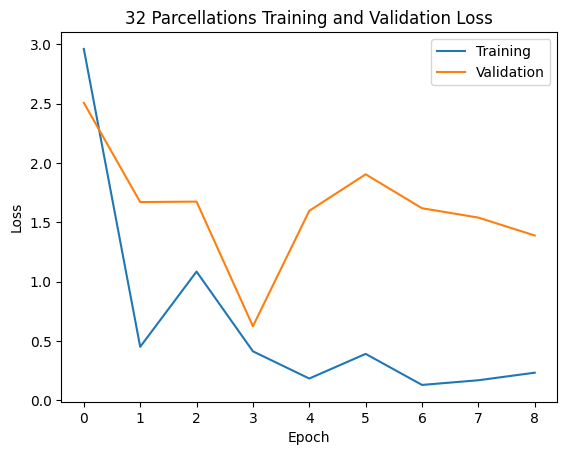

In [ ]:
#plot_until = epoch_min_val_loss +1
plot_until = epoch_max_val_acc +1
idx = b
plt.plot(range(0,plot_until), all_iter_train_acc[idx][0:plot_until])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.plot(range(0,plot_until), all_iter_val_acc[idx][0:plot_until])
plt.legend(["Training", "Validation"], loc ="lower right")
plt.title("32 Parcellations Training and Validation Accuracy")
plt.show()

plt.plot(range(0,plot_until), all_iter_train_loss[idx][0:plot_until])
plt.plot(range(0,plot_until), all_iter_test_loss[idx][0:plot_until])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("32 Parcellations Training and Validation Loss")
plt.show()

# Synthseg with 32 Regions

In [ ]:
from nilearn import image, plotting, datasets, signal
from nilearn.maskers import NiftiMapsMasker
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
files = os.listdir('/content/connectivity_pd/synthsegtimeseries')
path = '/content/connectivity_pd/synthsegtimeseries'
shape = []
for f in files:
  time_series_file = os.path.join(path, f)
  time_series = np.loadtxt(time_series_file, dtype=float, delimiter=',')
  shape.append(time_series.shape)

In [ ]:
time_series = []
labels = []
shapes = []
for i, csv_file in enumerate(sorted(os.listdir(path))):
  time_series_file = os.path.join(path, csv_file)

  time_series.append(np.loadtxt(time_series_file, dtype=float, delimiter=','))
  labels.append(int(int(csv_file[12]) == 1))

In [ ]:
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from nilearn.connectome import ConnectivityMeasure

corr_measure = ConnectivityMeasure(kind='correlation')
pcorr_measure = ConnectivityMeasure(kind='partial correlation')

corr_matrices = corr_measure.fit_transform(time_series)
pcorr_matrices = pcorr_measure.fit_transform(time_series)

graphs = []
neighbors = 20
for i in range(0, len(corr_matrices)):
    index = np.abs(pcorr_matrices[i]).argsort(axis=1)
    n_rois = pcorr_matrices[i].shape[0]

    # Take only the top k correlates to reduce number of edges
    for j in range(n_rois):
        for k in range(n_rois - neighbors):
            pcorr_matrices[i][j, index[j, k]] = 0
        for k in range(n_rois - neighbors, n_rois):
            pcorr_matrices[i][j, index[j, k]] = 1

    pcorr_matrix_nx = nx.from_numpy_array(pcorr_matrices[i])
    pcorr_matrix_data = from_networkx(pcorr_matrix_nx)
    pcorr_matrix_data.x = torch.tensor(corr_matrices[i]).float()
    pcorr_matrix_data.y = torch.tensor(labels[i], dtype=torch.long)
    #pcorr_matrix_data = np.array(pcorr_matrix_data)
    graphs.append(pcorr_matrix_data)

/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/usr/local/lib/python3.10/dist-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/usr/local/lib/python3.10/dist

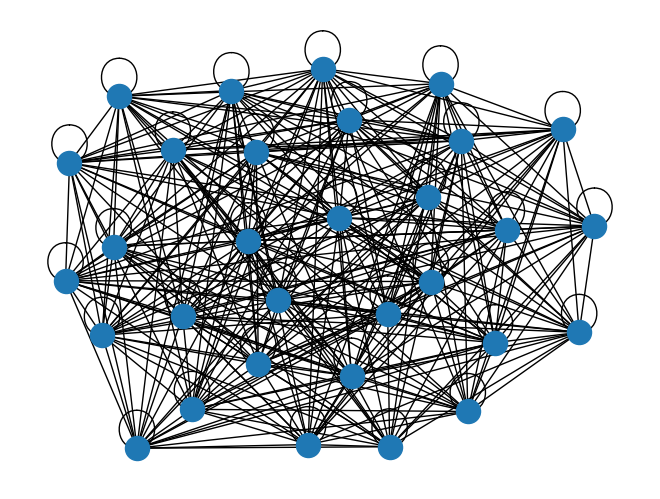

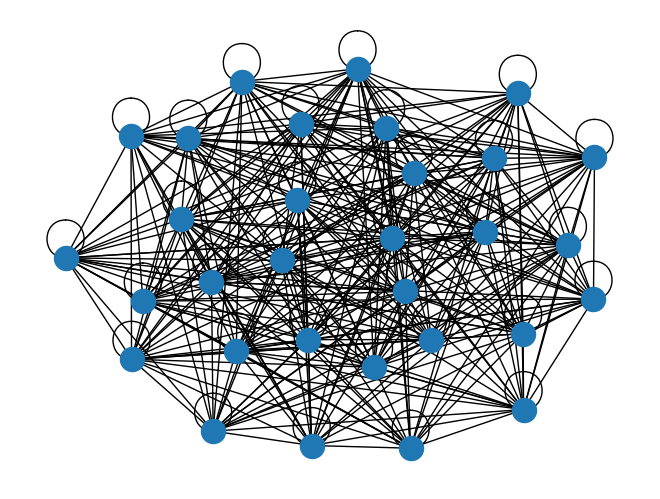

In [ ]:
from torch_geometric.utils.convert import to_networkx
g = to_networkx(graphs[78], to_undirected=True)
nx.draw(g)

plt.figure()
g = to_networkx(graphs[2], to_undirected=True)
nx.draw(g)

In [ ]:

import numpy as np
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random

def test_hyperParams(lr,num_epochs,threshold,batchsize):
  lr = lr
  num_epochs = num_epochs
  threshold = threshold
  batch_size = batchsize
  criterion = torch.nn.BCELoss()
  model = GCN(num_node_features=31, hidden_channels=128)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  torch.manual_seed(12345)
  random.shuffle(graphs)
  train_size = int(0.8 * len(graphs))
  val_size = len(graphs) - train_size
  train_dataset, val_dataset = random_split(graphs, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    #print(len(train_loader.dataset))
    #print(len(valid_loader.dataset))

  all_train_acc = []
  all_val_acc = []
  all_train_loss = []
  all_test_loss = []


  for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer)
    train_acc, bceloss_train = test(model, train_loader, threshold)
    val_acc, bceloss_test = test(model, valid_loader, threshold)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)
    all_train_loss.append(bceloss_train)
    all_test_loss.append(bceloss_test)


  return all_train_acc, all_val_acc, all_train_loss, all_test_loss



In [ ]:
import numpy as np
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random

lrs = [1e-1, 1e-2, 1e-3]
nums_epochs = [10, 20, 30, 40, 50]
ts = [0.6, 0.7, 0.75]
batchsizes = [16, 20, 22]


all_iter_train_acc = []
all_iter_val_acc = []
all_iter_train_loss = []
all_iter_test_loss = []

hp_set = []
trainlosses = []
testlosses = []
trainacc = []
valacc = []
it = 0
avg_losses = []
for n in nums_epochs:
  for r in lrs:
    for t in ts:
      for b in batchsizes:
        all_train_acc, all_val_acc, all_train_loss, all_test_loss = test_hyperParams(r, n, t, b)
        min_train_loss = np.min(all_train_loss)
        min_test_loss = np.min(all_test_loss)
        max_train_acc = np.max(all_train_acc)
        max_val_acc = np.max(all_val_acc)
        print('best training accuracy:', max_train_acc,'\n', 'best validation accuracy:', max_val_acc, '\n',
              'best training loss:', min_train_loss,'\n',
              'best test loss:', min_test_loss, '\n', '------------------------------------------------' )
        print('num_epochs', n, 'lr', r, 'threshold',t, 'batch size', b, '\n', '------------------------------------------------')
        hp_set.append(['num_epochs', n, 'lr', r, 'threshold', t, 'batch size', b])
        trainlosses.append(min_train_loss)
        testlosses.append(min_test_loss)
        avg_loss = (min_train_loss + min_test_loss )/ 2
        avg_losses.append(avg_loss)
        trainacc.append(max_train_acc)
        valacc.append(max_val_acc)
        all_iter_train_acc.append(all_train_acc)
        all_iter_val_acc.append(all_val_acc)
        all_iter_train_loss.append(all_train_loss)
        all_iter_test_loss.append(all_test_loss)

        it += 1
print('------------------------------------------------------------------------------------------')
v = testlosses.index(np.min(testlosses))
print('iteration with the best test losses:', v)
epoch_min_val_loss = all_iter_test_loss[v].index(np.min(testlosses))
print('hyperparams:', hp_set[v],'\n','validation accuracy:', np.max(all_iter_val_acc[v]),
      'val loss:', testlosses[v],'\n' ,'train loss:', trainlosses[v], '\n' ,
      'train accuracy:', trainacc[v])
print('epoch of min val loss:', epoch_min_val_loss )
print('-----------------------------------------------------------------------------------------')

b = valacc.index(np.max(valacc))
print('iteration with the best validation accuracy:', b)
epoch_max_val_acc = all_iter_val_acc[b].index(np.max(valacc))
print('hyperparams:', hp_set[b],'\n','validation accuracy:', np.max(all_iter_val_acc[b]),
      'val loss:', np.min(all_iter_test_loss[b]),'\n' ,'train loss:', trainlosses[b], '\n' ,
      'train accuracy:', trainacc[b])
print('epoch of max val accuracy:', epoch_max_val_acc )
print('-----------------------------------------------------------------------------------------')

c = trainacc.index(np.max(trainacc))
print('iteration with the best train accuracy:', c)
epoch_max_train_acc = all_iter_train_acc[c].index(np.max(trainacc))
print('hyperparams:', hp_set[c],'\n','validation accuracy:', np.max(all_iter_val_acc[c]),
      'val loss:', testlosses[c],'\n' ,'train loss:', trainlosses[c], '\n' ,
      'train accuracy:', trainacc[c])
print('epoch of max train accuracy:', epoch_max_train_acc )
print('-----------------------------------------------------------------------------------------')



best training accuracy: 0.7746479 
 best validation accuracy: 0.8333333 
 best training loss: 2.9786384105682373 
 best test loss: 0.0 
 ------------------------------------------------
num_epochs 10 lr 0.1 threshold 0.6 batch size 16 
 ------------------------------------------------
best training accuracy: 0.7746479 
 best validation accuracy: 0.7777778 
 best training loss: 0.2540004253387451 
 best test loss: 0.5140021443367004 
 ------------------------------------------------
num_epochs 10 lr 0.1 threshold 0.6 batch size 20 
 ------------------------------------------------
best training accuracy: 0.7887324 
 best validation accuracy: 0.6666667 
 best training loss: 0.010385249741375446 
 best test loss: 2.081278085708618 
 ------------------------------------------------
num_epochs 10 lr 0.1 threshold 0.6 batch size 22 
 ------------------------------------------------
best training accuracy: 0.74647886 
 best validation accuracy: 0.7777778 
 best training loss: 0.08404881507158

In [ ]:
print('------------------------------------------------------------------------------------------')
v = testlosses.index(np.min(testlosses))
print('iteration with the best test losses:', v)
epoch_min_val_loss = all_iter_test_loss[v].index(np.min(testlosses))
print('hyperparams:', hp_set[v],'\n','validation accuracy:', np.max(all_iter_val_acc[v]),
      'val loss:', testlosses[v],'\n' ,'train loss:', trainlosses[v], '\n' ,
      'train accuracy:', trainacc[v])
print('epoch of min val loss:', epoch_min_val_loss )
print('-----------------------------------------------------------------------------------------')

b = valacc.index(np.max(valacc))
print('iteration with the best validation accuracy:', b)
epoch_max_val_acc = all_iter_val_acc[b].index(np.max(valacc))
print('hyperparams:', hp_set[b],'\n','validation accuracy:', np.max(all_iter_val_acc[b]),
      'val loss:', np.min(all_iter_test_loss[b]),'\n' ,'train loss:', trainlosses[b], '\n' ,
      'train accuracy:', trainacc[b])
print('epoch of max val accuracy:', epoch_max_val_acc )
print('-----------------------------------------------------------------------------------------')

c = trainacc.index(np.max(trainacc))
print('iteration with the best train accuracy:', c)
epoch_max_train_acc = all_iter_train_acc[c].index(np.max(trainacc))
print('hyperparams:', hp_set[c],'\n','validation accuracy:', np.max(all_iter_val_acc[c]),
      'val loss:', testlosses[c],'\n' ,'train loss:', trainlosses[c], '\n' ,
      'train accuracy:', trainacc[c])
print('epoch of max train accuracy:', epoch_max_train_acc )
print('-----------------------------------------------------------------------------------------')



------------------------------------------------------------------------------------------
iteration with the best test losses: 0
hyperparams: ['num_epochs', 10, 'lr', 0.1, 'threshold', 0.6, 'batch size', 16] 
 validation accuracy: 0.8333333 val loss: 0.0 
 train loss: 2.9786384105682373 
 train accuracy: 0.7746479
epoch of min val loss: 0
-----------------------------------------------------------------------------------------
iteration with the best validation accuracy: 35
hyperparams: ['num_epochs', 20, 'lr', 0.1, 'threshold', 0.75, 'batch size', 22] 
 validation accuracy: 0.9444444 val loss: 0.3373330235481262 
 train loss: 0.0020550661720335484 
 train accuracy: 0.8873239
epoch of max val accuracy: 10
-----------------------------------------------------------------------------------------
iteration with the best train accuracy: 36
hyperparams: ['num_epochs', 20, 'lr', 0.01, 'threshold', 0.6, 'batch size', 16] 
 validation accuracy: 0.8888889 val loss: 1.409201567506487e-16 
 trai

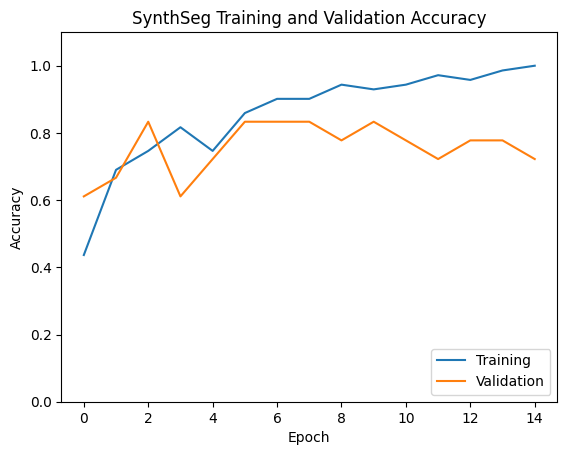

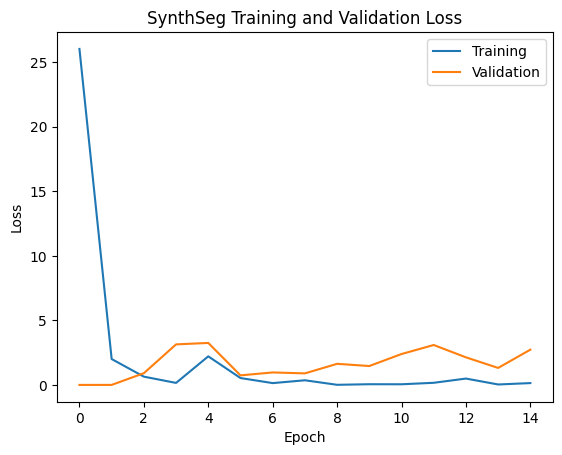

In [ ]:
plot_until = epoch_max_train_acc +1
#plot_until = epoch_max_val_acc +1
idx = c
plt.plot(range(0,plot_until), all_iter_train_acc[idx][0:plot_until])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.plot(range(0,plot_until), all_iter_val_acc[idx][0:plot_until])
plt.legend(["Training", "Validation"], loc ="lower right")
plt.title("SynthSeg Training and Validation Accuracy")
plt.show()

plt.plot(range(0,plot_until), all_iter_train_loss[idx][0:plot_until])
plt.plot(range(0,plot_until), all_iter_test_loss[idx][0:plot_until])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("SynthSeg Training and Validation Loss")
plt.show()

In [ ]:
#TEST ONE SET OF HYPERPARAMS
import numpy as np
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch_geometric.loader import DataLoader
import random


#num_epochs 50 lr 0.01 threshold 0.6 batch size 20
#hyperparams: ['num_epochs', 30,
# 'lr', 0.001, 'threshold', 0.6, 'batch size', 16]

lr = .01
ne = 30
thresh = 0.7
bs = 22

all_1_train_acc = []
all_1_val_acc = []
all_1_train_loss = []
all_1_test_loss = []


all_train_acc1, all_val_acc1, all_train_loss1, all_test_loss1 = test_hyperParams(lr, ne, thresh, bs)
min_train_loss1 = np.min(all_train_loss1)
min_test_loss1 = np.min(all_test_loss1)
max_train_acc1 = np.max(all_train_acc1)
max_val_acc1 = np.max(all_val_acc1)
print('best training accuracy:', max_train_acc1, '\n',
      'best validation accuracy:', max_val_acc1, '\n',
      'best training loss:', min_train_loss1, '\n',
      'best test loss:', min_test_loss1, '\n',
      '------------------------------------------------' )
print('num_epochs', ne, 'lr', lr, 'threshold',thresh, 'batch size', bs, '\n',
      '------------------------------------------------')


best training accuracy: 1.0 
 best validation accuracy: 0.8888889 
 best training loss: 0.009222195483744144 
 best test loss: 0.6120462417602539 
 ------------------------------------------------
num_epochs 30 lr 0.01 threshold 0.7 batch size 22 
 ------------------------------------------------


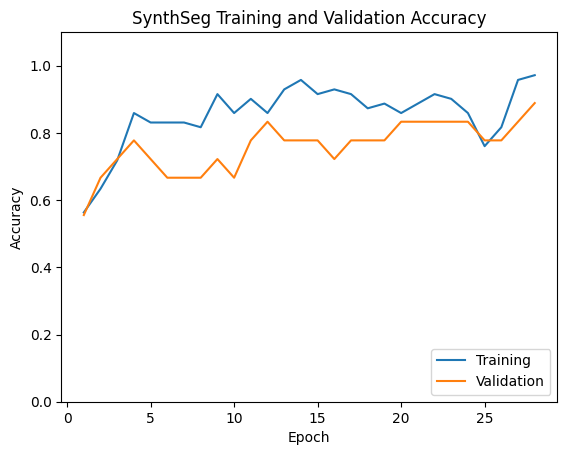

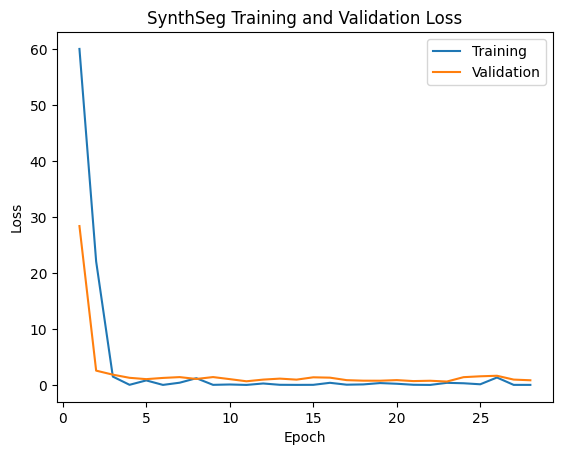

In [ ]:

#plot_until = all_test_loss1.index(min_test_loss1) +1
plot_until = all_val_acc1.index(max_val_acc1) +1
#plot_until = ne
#plot_until = 75
plt.plot(range(1,plot_until+1), all_train_acc1[0:plot_until])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.plot(range(1,plot_until+1), all_val_acc1[0:plot_until])
plt.legend(["Training", "Validation"], loc ="lower right")
plt.title("SynthSeg Training and Validation Accuracy")
plt.show()

plt.plot(range(1,plot_until+1), all_train_loss1[0:plot_until])
plt.plot(range(1,plot_until+1), all_test_loss1[0:plot_until])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("SynthSeg Training and Validation Loss")
plt.show()




# Experiment 3

In [ ]:
class GCNModel(torch.nn.Module):
  def __init__(self, num_node_features, hidden_channels, drop_rate):
    super().__init__()
    self.conv1 = gnn.GraphConv(num_node_features, hidden_channels)
    self.pool1 = gnn.TopKPooling(hidden_channels, ratio=0.8)
    self.conv2 = gnn.GraphConv(hidden_channels, hidden_channels)
    self.pool2 = gnn.TopKPooling(hidden_channels, ratio=0.8)
    self.conv3 = gnn.GraphConv(hidden_channels, hidden_channels)
    self.pool3 = gnn.TopKPooling(hidden_channels, ratio=0.8)
    self.lin1 = Linear(256, 128)
    self.lin2 = Linear(128, 64)
    self.lin3 = Linear(64, 1)
    self.bn1 = BatchNorm1d(hidden_channels)
    self.bn2 = BatchNorm1d(64)
    self.dropout = Dropout(drop_rate)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    gcn1 = F.relu(self.conv1(x, edge_index))
    pool1, edge_index, _, batch, _, _ = self.pool1(gcn1, edge_index, None, batch)
    x1 = torch.cat([gnn.global_max_pool(pool1, batch), gnn.global_mean_pool(pool1, batch)], dim=1)

    gcn2 = F.relu(self.conv2(pool1, edge_index))
    pool2, edge_index, _, batch, _, _ = self.pool2(gcn2, edge_index, None, batch)
    x2 = torch.cat([gnn.global_max_pool(pool2, batch), gnn.global_mean_pool(pool2, batch)], dim=1)

    gcn3 = F.relu(self.conv3(pool2, edge_index))
    pool3, edge_index, _, batch, _, _ = self.pool3(gcn3, edge_index, None, batch)
    x3 = torch.cat([gnn.global_max_pool(pool3, batch), gnn.global_mean_pool(pool3, batch)], dim=1)

    x = x1 + x2 + x3
    fc1 = self.dropout(F.relu(self.bn1(self.lin1(x))))
    fc2 = F.relu(self.bn2(self.lin2(fc1)))
    fc3 = F.sigmoid(self.lin3(fc2))

    return fc3

In [ ]:
def train(model, train_loader):
  model.train()
  for data in train_loader:
    y = data.y.unsqueeze(1)
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.float(), y.float())
    loss.backward()
    optimizer.step()

def test(model, loader):
  model.eval()
  correct = 0
  for data in loader:
    y = data.y.unsqueeze(1)
    out = model(data)
    pred = torch.where(out > thresh, 1, 0)
    loss = criterion(out.float(), y.float())
    correct += torch.eq(y, pred).sum()
  return correct / len(loader.dataset), loss.item()

## Baseline Hyperparameters from Literature for Schizophrenia

In [ ]:
lr = 1e-4
criterion = torch.nn.BCELoss()
num_epochs = 30
thresh = 0.5
batch_size = 10
torch.manual_seed(12345)
random.shuffle(graphs)
train_size = int(0.8 * len(graphs))
val_size = len(graphs) - train_size
train_dataset, val_dataset = random_split(graphs, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model = GCNModel(num_node_features=50, hidden_channels=128, drop_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_test_loss = []

for epoch in range(1, num_epochs+1):
  train(model, train_loader)
  train_acc, bceloss_train = test(model, train_loader)
  val_acc, bceloss_test = test(model, valid_loader)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}, Training Loss: {bceloss_train:.4f}, Validation Loss: {bceloss_test:.4f}')
  all_train_acc.append(train_acc)
  all_val_acc.append(val_acc)
  all_train_loss.append(bceloss_train)
  all_test_loss.append(bceloss_test)

Epoch: 001, Train Acc: 0.6111, Validation Acc: 0.3684, Training Loss: 0.7197, Validation Loss: 0.7450
Epoch: 002, Train Acc: 0.7361, Validation Acc: 0.4211, Training Loss: 0.6409, Validation Loss: 0.7557
Epoch: 003, Train Acc: 0.7083, Validation Acc: 0.4737, Training Loss: 0.6045, Validation Loss: 0.7404
Epoch: 004, Train Acc: 0.6944, Validation Acc: 0.4737, Training Loss: 0.5679, Validation Loss: 0.7632
Epoch: 005, Train Acc: 0.7361, Validation Acc: 0.4211, Training Loss: 0.4498, Validation Loss: 0.8253
Epoch: 006, Train Acc: 0.8056, Validation Acc: 0.4737, Training Loss: 0.5536, Validation Loss: 0.7914
Epoch: 007, Train Acc: 0.8333, Validation Acc: 0.4737, Training Loss: 0.4990, Validation Loss: 0.7967
Epoch: 008, Train Acc: 0.8472, Validation Acc: 0.4211, Training Loss: 0.5133, Validation Loss: 0.8785
Epoch: 009, Train Acc: 0.8472, Validation Acc: 0.5789, Training Loss: 0.4434, Validation Loss: 0.6005
Epoch: 010, Train Acc: 0.8056, Validation Acc: 0.6316, Training Loss: 0.4281, Vali

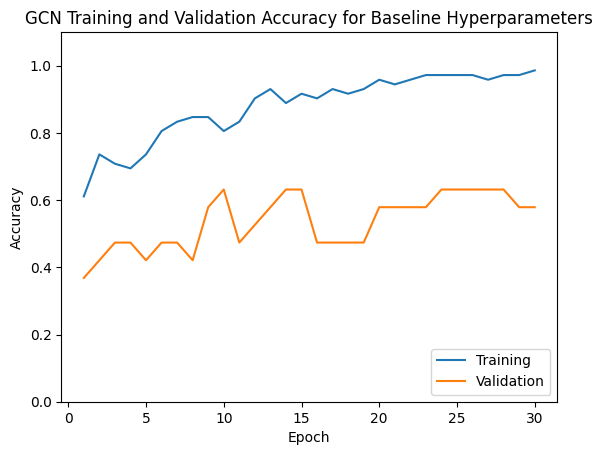

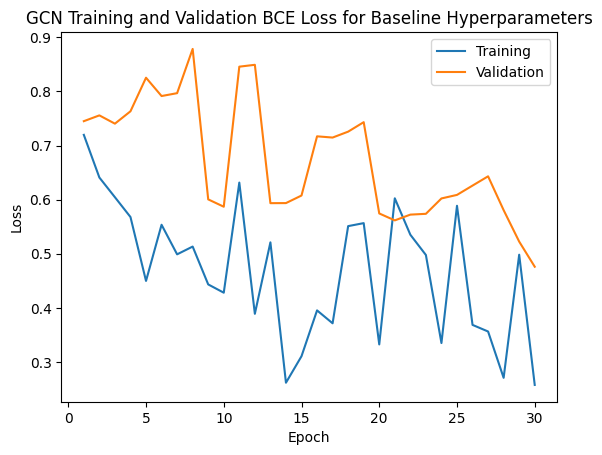

In [ ]:
plt.plot(range(1, num_epochs+1), all_train_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.plot(range(1, num_epochs+1), all_val_acc)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.title("GCN Training and Validation Accuracy for Baseline Hyperparameters")
plt.show()

plt.plot(range(1, num_epochs+1), all_train_loss)
plt.plot(range(1, num_epochs+1), all_test_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("GCN Training and Validation BCE Loss for Baseline Hyperparameters")
plt.show()

## Optimized Hyperparameters for Parkinson's

In [ ]:
lr = 1e-3
criterion = torch.nn.BCELoss()
num_epochs = 30
thresh = 0.5
batch_size = 64
torch.manual_seed(12345)
random.shuffle(graphs)
train_size = int(0.8 * len(graphs))
val_size = len(graphs) - train_size
train_dataset, val_dataset = random_split(graphs, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model = GCNModel(num_node_features=50, hidden_channels=128, drop_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_test_loss = []

for epoch in range(1, num_epochs+1):
  train(model, train_loader)
  train_acc, bceloss_train = test(model, train_loader)
  val_acc, bceloss_test = test(model, valid_loader)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}, Training Loss: {bceloss_train:.4f}, Validation Loss: {bceloss_test:.4f}')
  all_train_acc.append(train_acc)
  all_val_acc.append(val_acc)
  all_train_loss.append(bceloss_train)
  all_test_loss.append(bceloss_test)

Epoch: 001, Train Acc: 0.6111, Validation Acc: 0.6316, Training Loss: 0.6716, Validation Loss: 0.7896
Epoch: 002, Train Acc: 0.5417, Validation Acc: 0.5263, Training Loss: 0.7260, Validation Loss: 0.8455
Epoch: 003, Train Acc: 0.6111, Validation Acc: 0.5263, Training Loss: 0.6126, Validation Loss: 0.8618
Epoch: 004, Train Acc: 0.5972, Validation Acc: 0.5263, Training Loss: 0.6942, Validation Loss: 0.8537
Epoch: 005, Train Acc: 0.5556, Validation Acc: 0.5263, Training Loss: 0.7566, Validation Loss: 0.8326
Epoch: 006, Train Acc: 0.5833, Validation Acc: 0.5263, Training Loss: 0.6026, Validation Loss: 0.8096
Epoch: 007, Train Acc: 0.5833, Validation Acc: 0.4737, Training Loss: 0.6251, Validation Loss: 0.7739
Epoch: 008, Train Acc: 0.6944, Validation Acc: 0.4737, Training Loss: 0.6850, Validation Loss: 0.7585
Epoch: 009, Train Acc: 0.7639, Validation Acc: 0.5263, Training Loss: 0.5841, Validation Loss: 0.7487
Epoch: 010, Train Acc: 0.7361, Validation Acc: 0.4737, Training Loss: 0.5329, Vali

In [ ]:
plt.plot(range(1, num_epochs+1), all_train_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.plot(range(1, num_epochs+1), all_val_acc)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.title("GCN Training and Validation Accuracy for Baseline Hyperparameters")
plt.show()

plt.plot(range(1, num_epochs+1), all_train_loss)
plt.plot(range(1, num_epochs+1), all_test_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("GCN Training and Validation BCE Loss for Baseline Hyperparameters")
plt.show()

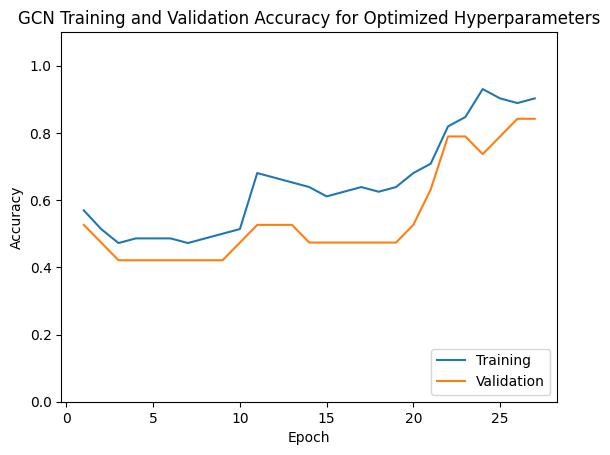

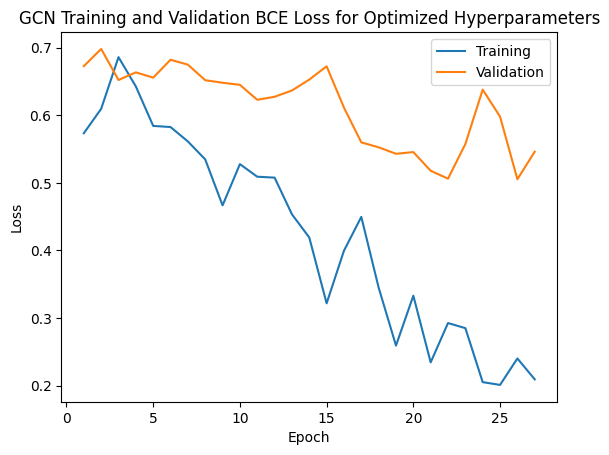